In [53]:
import seed_data
# Limit for each gen
kanto = 151
johto = 251
hoenn = 386
sinnoh = 493
unova = 649
kalos = 721
alola = 807
galar = 898
# Seed data on kalos region
seed_data.seed(kanto)
# It can take some minutes depending on your limit

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('pokemon.csv')

# Display first 5 rows to inspect the dataset
df.head()

,name,id,abilities,hp,attack,defense,special-attack,special-defense,speed,type1,type2
0,bulbasaur,1,"['overgrow', 'chlorophyll']",45,49,49,65,65,45,grass,poison
1,ivysaur,2,"['overgrow', 'chlorophyll']",60,62,63,80,80,60,grass,poison
2,venusaur,3,"['overgrow', 'chlorophyll']",80,82,83,100,100,80,grass,poison
3,charmander,4,"['blaze', 'solar-power']",39,52,43,60,50,65,fire,NaN
4,charmeleon,5,"['blaze', 'solar-power']",58,64,58,80,65,80,fire,NaN


In [2]:
from sklearn.preprocessing import MultiLabelBinarizer

# Parse abilities column from string to list
df['abilities'] = df['abilities'].apply(lambda x: eval(x))  # Convert string representation to Python list

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Transform abilities into binary columns
abilities_encoded = mlb.fit_transform(df['abilities'])

# Convert the binary columns into a DataFrame with ability names as column headers
abilities_df = pd.DataFrame(abilities_encoded, columns=mlb.classes_)

# Concatenate the abilities DataFrame with the original DataFrame
df = pd.concat([df, abilities_df], axis=1)

# Drop the original abilities column, as it is now encoded
df = df.drop('abilities', axis=1)

# Display first few rows to confirm encoding
df.head()


,name,id,hp,attack,defense,special-attack,special-defense,speed,type1,type2,...,vital-spirit,volt-absorb,water-absorb,water-veil,weak-armor,white-smoke,wind-rider,wonder-guard,wonder-skin,zen-mode
0,bulbasaur,1,45,49,49,65,65,45,grass,poison,...,0,0,0,0,0,0,0,0,0,0
1,ivysaur,2,60,62,63,80,80,60,grass,poison,...,0,0,0,0,0,0,0,0,0,0
2,venusaur,3,80,82,83,100,100,80,grass,poison,...,0,0,0,0,0,0,0,0,0,0
3,charmander,4,39,52,43,60,50,65,fire,NaN,...,0,0,0,0,0,0,0,0,0,0
4,charmeleon,5,58,64,58,80,65,80,fire,NaN,...,0,0,0,0,0,0,0,0,0,0


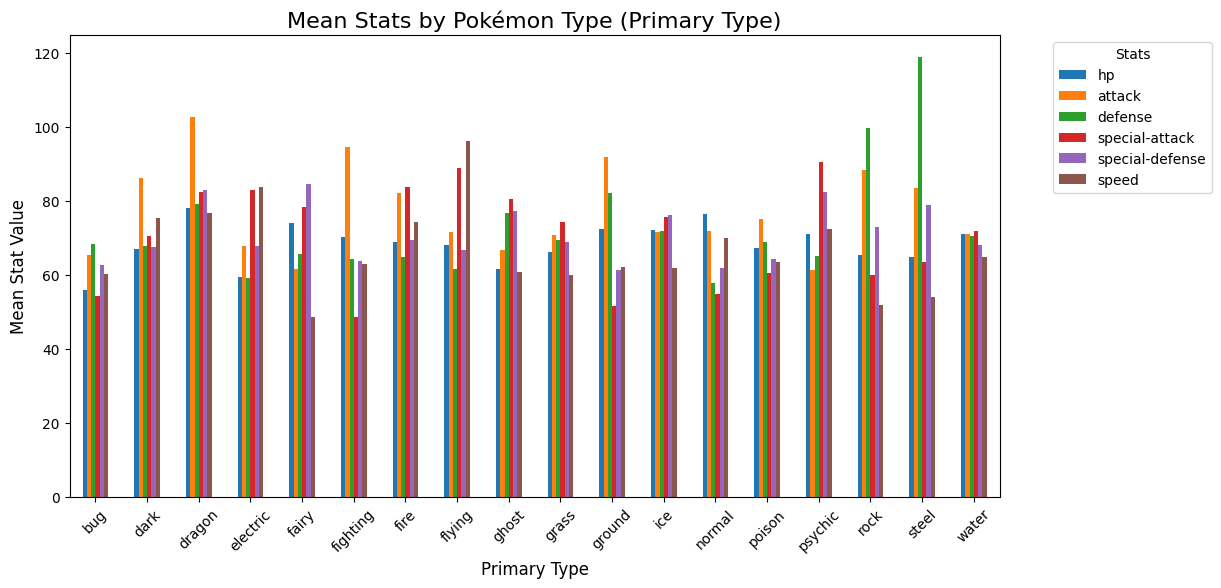

In [3]:
# DATA ANALYSIS
import matplotlib.pyplot as plt

numeric_columns = ['hp', 'attack', 'defense', 'special-attack', 'special-defense', 'speed']

# Group by the 'type1' (primary type) and calculate the mean of numeric stats
mean_stats = df.groupby('type1')[numeric_columns].mean()
# Plot mean stats by type
fig, ax = plt.subplots(figsize=(12, 6))
mean_stats.plot(kind='bar', ax=ax)

# Add title and labels
ax.set_title('Mean Stats by Pokémon Type (Primary Type)', fontsize=16)
ax.set_xlabel('Primary Type', fontsize=12)
ax.set_ylabel('Mean Stat Value', fontsize=12)
ax.legend(title='Stats', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=45)
plt.show()


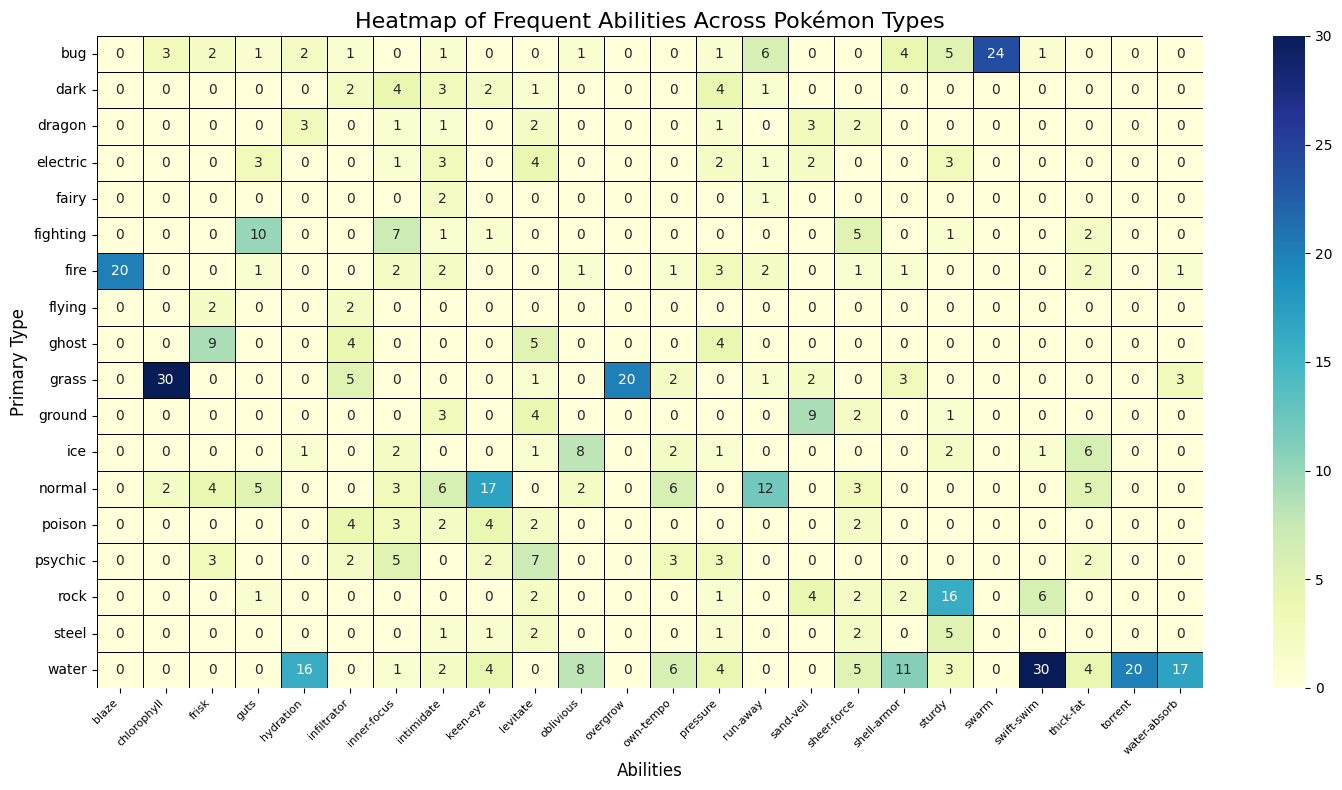

In [35]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Filter abilities with high frequency (optional threshold)
# We keep abilities that appear in at least 10 Pokémon to reduce clutter.
ability_sums = df[mlb.classes_].sum()
frequent_abilities = ability_sums[ability_sums >= 20].index  # Filter out rare abilities

# Step 2: Group by 'type1' and sum binary ability columns, then filter frequent abilities
abilities_by_type = df.groupby('type1').sum()[frequent_abilities]

# Step 3: Create the heatmap using seaborn
plt.figure(figsize=(15, 8))
sns.heatmap(
    abilities_by_type, 
    cmap='YlGnBu',  # Color scheme
    annot=True,  # Show the actual numbers in each cell
    fmt='d',  # Integer format for annotations
    linewidths=0.5,  # Add grid lines
    linecolor='black'
)

# Step 4: Add title and labels
plt.title('Heatmap of Frequent Abilities Across Pokémon Types', fontsize=16)
plt.xlabel('Abilities', fontsize=12)
plt.ylabel('Primary Type', fontsize=12)

# Adjust tick label size for better readability
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()


In [4]:
from sklearn.preprocessing import LabelEncoder

# Encode the 'type1' column (target variable)
le = LabelEncoder()
df['type1_encoded'] = le.fit_transform(df['type1'])

# Check the unique mappings for clarity
print(dict(zip(le.classes_, range(len(le.classes_)))))


{'bug': 0, 'dark': 1, 'dragon': 2, 'electric': 3, 'fairy': 4, 'fighting': 5, 'fire': 6, 'flying': 7, 'ghost': 8, 'grass': 9, 'ground': 10, 'ice': 11, 'normal': 12, 'poison': 13, 'psychic': 14, 'rock': 15, 'steel': 16, 'water': 17}


In [18]:
from sklearn.model_selection import train_test_split

# Features: All stats, abilities columns, Target: Encoded primary type
# X is all columns except 'type1' and 'type1_encoded' name id
X = df.drop(['type1', 'type1_encoded', 'name', 'id','type2'], axis=1)
y = df['type1_encoded']

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Training Set Size: {X_train.shape}, Test Set Size: {X_test.shape}')


Training Set Size: (576, 196), Test Set Size: (145, 196)


In [25]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest with 100 estimators
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training set
rf.fit(X_train, y_train)

print('Random Forest Model Trained Successfully!')


Random Forest Model Trained Successfully!


In [26]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on the test set
y_pred = rf.predict(X_test)

# Print classification report and accuracy
#print('Classification Report:\n', classification_report(y_test, y_pred, target_names=le.classes_))
print('Accuracy:', accuracy_score(y_test, y_pred))


Accuracy: 0.6275862068965518


In [61]:


# create a ability list
ability_list = list(abilities_df.columns)
example_df = pd.DataFrame({
    'hp': [80],
    'attack': [150],
    'defense': [40],
    'special-attack': [100],
    'special-defense': [100],
    'speed': [80],
    # fill the rest of the abilities with 0 else if it is overgrow, then fill 1
    **{ability: (1 if ability == 'pressure' else 0) for ability in ability_list},
})

# Predict the type of the example Pokémon
predicted_type = rf.predict(example_df)

# Decode the predicted type

predicted_type = le.inverse_transform(predicted_type)
print('Predicted Type:', predicted_type[0])


Predicted Type: dragon
